In [12]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from mplsoccer import PyPizza,add_image,FontManager
from scipy import stats
import math
import matplotlib.pyplot as plt
from urllib.request import urlopen
from PIL import Image
pd.set_option('display.max_columns', None)

In [4]:
#scraping fbref data, reference to geek culture on medium
#https://medium.com/geekculture/an-introduction-to-football-player-dashboards-using-python-and-matplotlib-eb5328dfe85f

def readfromhtml(filepath):
    df = pd.read_html(filepath)[0]
    column_lst = list(df.columns)
    for index in range(len(column_lst)):
        column_lst[index] = column_lst[index][1]
        
    df.columns = column_lst
    df.drop(df[df['Player'] == 'Player'].index, inplace=True)
    df = df.fillna('0')
    df.set_index('Rk', drop=True, inplace=True)
    try:
        df['Comp'] = df['Comp'].apply(lambda x: ' '.join(x.split()[1:]))
        df['Nation'] = df['Nation'].astype(str)
        df['Nation'] = df['Nation'].apply(lambda x: x.split()[-1])
    except:
        print('Error in uploading file:' + filepath)
    finally:
        df = df.apply(pd.to_numeric, errors='ignore')
        return df

In [148]:
df1 = readfromhtml('https://fbref.com/en/comps/Big5/passing/players/Big-5-European-Leagues-Stats')

In [149]:
df2 = readfromhtml('https://fbref.com/en/comps/Big5/defense/players/Big-5-European-Leagues-Stats')

In [150]:
df3 = readfromhtml('https://fbref.com/en/comps/Big5/possession/players/Big-5-European-Leagues-Stats')

### Data Cleaning

In [151]:
df1 = df1[['Player','Pos','Comp','Cmp%','TotDist','PrgDist','Att','Prog']]

In [152]:
df1.columns = ['Player','Pos','Comp','Pass%','Cmp%','Cmp%','Cmp%','TotDist','PrgDist','Att','Short Pass Att','Att','Long Pass Att','Prog']

In [153]:
df1 = df1[['Player','Pos','Comp','Pass%','TotDist','PrgDist','Short Pass Att','Long Pass Att','Prog']]

In [154]:
df2 = df2[['Player','Pos','Comp','TklW','Def 3rd','Att 3rd','Press','Succ','Tkl+Int']]

In [155]:
df2.columns = ['Player','Pos','Comp','TklW','Def 3rd','Press Def 3rd','Att 3rd','Press Att 3rd','Press','Press Succ','Tkl+Int']

In [156]:
df2 = df2[['Player','Pos','Comp','TklW','Press Def 3rd','Press Att 3rd','Press','Press Succ','Tkl+Int']]

In [157]:
df3 = df3[['Player','Pos','Comp','90s','Touches','Att 3rd','Succ','Att','#Pl','CPA']]

In [158]:
df3.columns = ['Player','Pos','Comp','90s','Touches','Touches Att 3rd','Dribbles Succ','Dribbles Att','#Pl','CPA']

In [185]:
data = df1.merge(df2,on=['Player','Pos','Comp']).merge(df3,on=['Player','Pos','Comp'])

In [186]:
data = data[(data['Pos']=='DF')&(data['Comp']=='Premier League')&(data['90s']>=10.0)]

In [187]:
data.reset_index(inplace=True)

In [189]:
data.drop(['index','90s'],inplace=True,axis=1)

### Calculating Percentiles

In [195]:
params = list(data.columns[3:])
print(params)

['Pass%', 'TotDist', 'PrgDist', 'Short Pass Att', 'Long Pass Att', 'Prog', 'TklW', 'Press Def 3rd', 'Press Att 3rd', 'Press', 'Press Succ', 'Tkl+Int', 'Touches', 'Touches Att 3rd', 'Dribbles Succ', 'Dribbles Att', '#Pl', 'CPA']


In [198]:
saiss = data[data['Player']=='Romain Saïss']
saiss = saiss.iloc[:,3:].values.tolist()[0]
print(saiss)

[82.4, 29554.0, 13832.0, 483.0, 359.0, 120.0, 38.0, 162.0, 20.0, 283.0, 103.0, 141.0, 2111.0, 127.0, 5.0, 8.0, 6.0, 1.0]


In [199]:
values = []
for x in range(len(params)):
    values.append(math.floor(stats.percentileofscore(data[params[x]],saiss[x])))

### Visualization

In [229]:
URL = 'https://resources.premierleague.com/premierleague/photos/players/250x250/p107613.png'
image = Image.open(urlopen(URL))

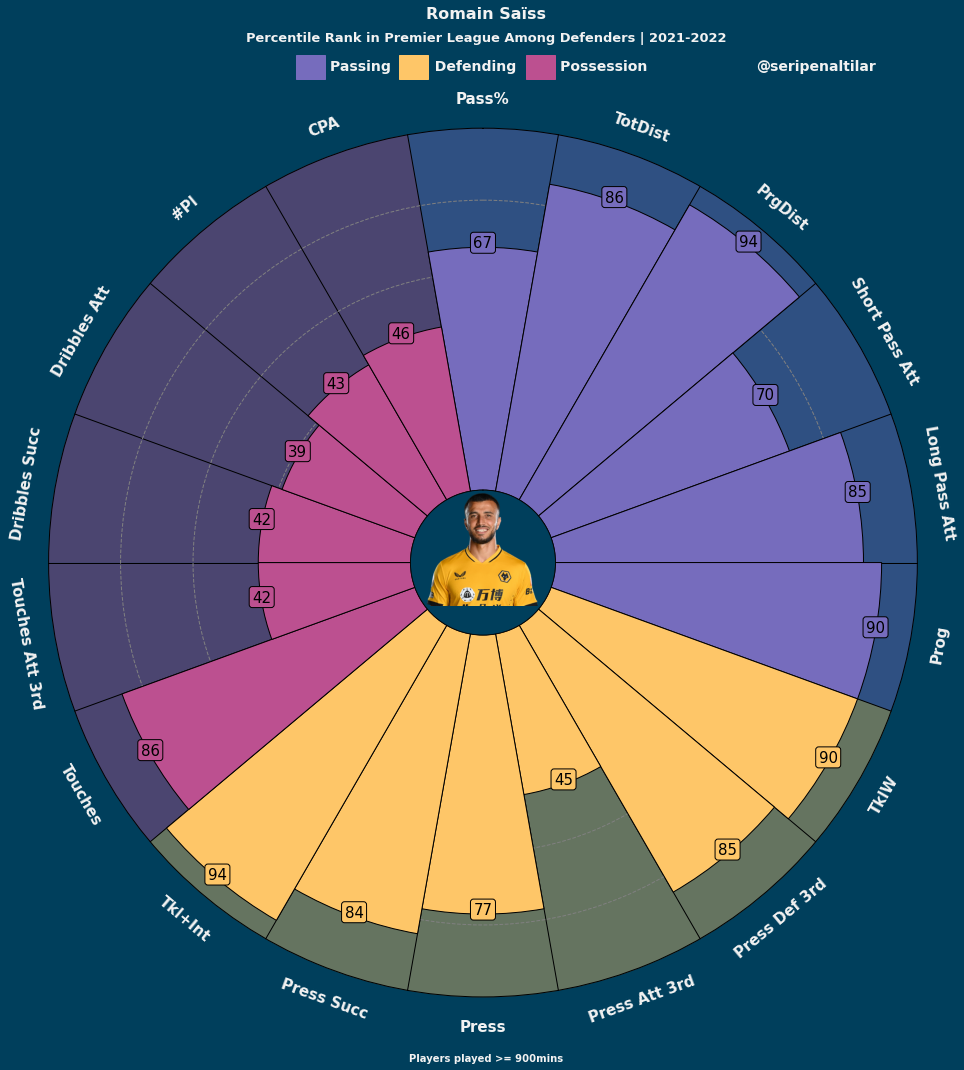

In [268]:
# color for the slices and text
slice_colors = ["#766cbd"] * 6 + ["#fec668"] * 6 + ["#bc5090"] * 6
text_colors = ["#000000"] * 18

# instantiate PyPizza class
baker = PyPizza(
    params=params,                  # list of parameters
    background_color="#003f5c",     # background color
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_color="#000000",    # color for last line
    last_circle_lw=2,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    inner_circle_size=20            # size of inner circle
)

# plot pizza
fig, ax = baker.make_pizza(
    values,                          # list of values
    figsize=(16, 16),                # adjust the figsize according to your need
    color_blank_space="same",        # use the same color to fill blank space
    slice_colors=slice_colors,       # color for individual slices
    value_colors=text_colors,        # color for the value-text
    value_bck_colors=slice_colors,   # color for the blank spaces
    blank_alpha=0.4,                 # alpha for blank-space colors
    kwargs_slices=dict(
        edgecolor="#000000", zorder=2, linewidth=1
    ),                               # values to be used when plotting slices
    kwargs_params=dict(
        color="#F2F2F2", fontsize=15, va="center" , weight='bold',
    ),                               # values to be used when adding parameter labels
    kwargs_values=dict(
        color="#F2F2F2", fontsize=15,zorder=3,
        bbox=dict(
            edgecolor="#000000",
            boxstyle="round,pad=0.2", lw=1
        )
    )                                
)

# add title
fig.text(
    0.515, 0.975, "Romain Saïss", size=16,
    ha="center", color="#F2F2F2",fontweight='bold'
)

# add subtitle
fig.text(
    0.515, 0.955,
    "Percentile Rank in Premier League Among Defenders | 2021-2022",
    size=13,
    ha="center", color="#F2F2F2",fontweight='bold'
)

# add text
fig.text(
    0.38, 0.93, "Passing         Defending         Possession", size=14,
    color="#F2F2F2",fontweight='bold'
)

fig.text(
    0.75, 0.93, "@seripenaltilar", size=14,
    color="#F2F2F2",fontweight='bold'
)

fig.text(
    0.515, 0.07, "Players played >= 900mins", size=10,
    ha="center", color="#F2F2F2",fontweight='bold'
)

# add rectangles
fig.patches.extend([
    plt.Rectangle(
        (0.35, 0.9225), 0.025, 0.021, fill=True, color="#766cbd",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.44, 0.9225), 0.025, 0.021, fill=True, color="#fec668",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.55, 0.9225), 0.025, 0.021, fill=True, color="#bc5090",
        transform=fig.transFigure, figure=fig
    ),
])

# add image
ax_image = add_image(
    image, fig, left=0.4615, bottom=0.45, width=0.10, height=0.13
)

plt.show()

### Daniel Barlaser

In [2]:
df = pd.read_csv('championship.csv')

In [3]:
params = list(df.columns[2:])
print(params)

['Tackles', 'Accurate passes %', 'Interceptions', 'Key passes', 'Acc. Long balls', 'Total passes', 'Expected Assist (xA)']


In [4]:
dan = df[df['Player']=='Daniel Barlaser']
dan = dan.iloc[:,2:].values.tolist()[0]
print(dan)

[2.4, 69.81, 1.8, 4.2, 4.8, 31.8, 1.0]


In [5]:
values = []
for x in range(len(params)):
    values.append(math.floor(stats.percentileofscore(df[params[x]],dan[x])))

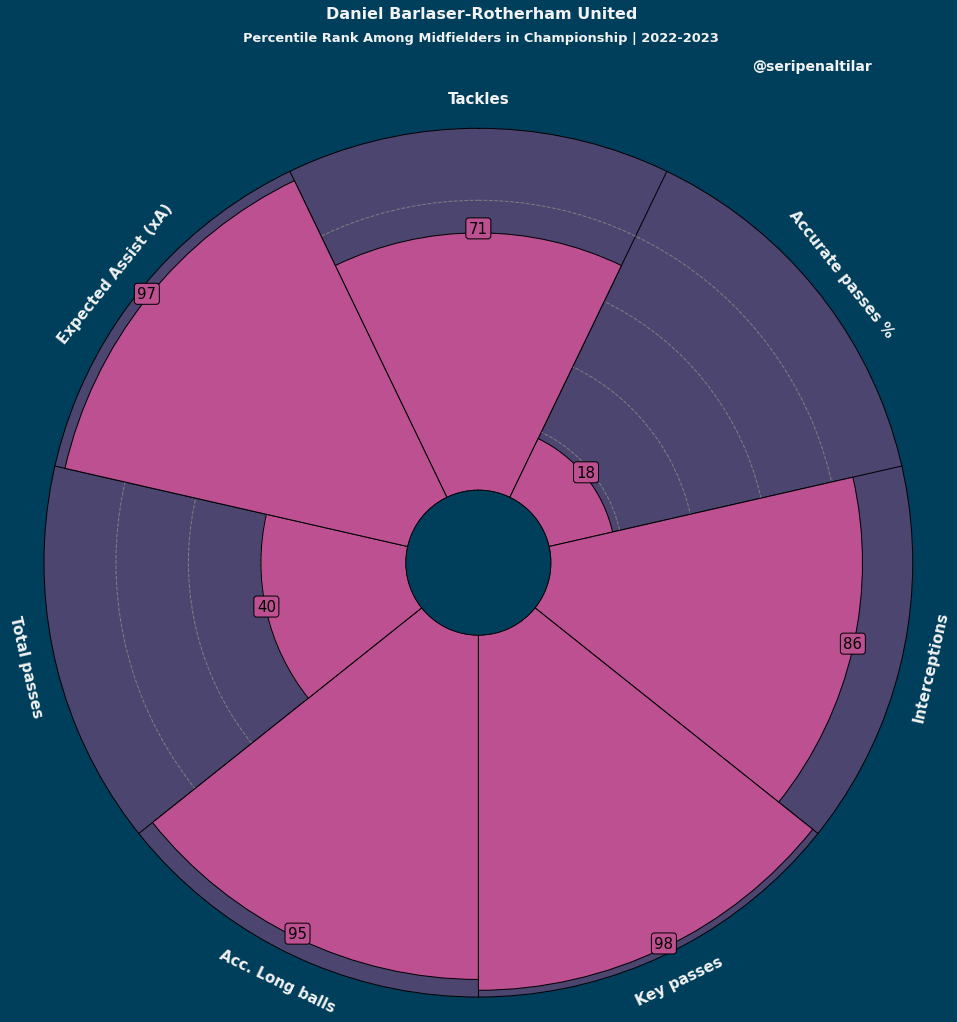

In [27]:
# color for the slices and text
slice_colors = ["#bc5090"] * 7
text_colors = ["#000000"] * 7

# instantiate PyPizza class
baker = PyPizza(
    params=params,                  # list of parameters
    background_color="#003f5c",     # background color
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_color="#000000",    # color for last line
    last_circle_lw=2,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    inner_circle_size=20            # size of inner circle
)

# plot pizza
fig, ax = baker.make_pizza(
    values,                          # list of values
    figsize=(16, 16),                # adjust the figsize according to your need
    color_blank_space="same",        # use the same color to fill blank space
    slice_colors=slice_colors,       # color for individual slices
    value_colors=text_colors,        # color for the value-text
    value_bck_colors=slice_colors,   # color for the blank spaces
    blank_alpha=0.4,                 # alpha for blank-space colors
    kwargs_slices=dict(
        edgecolor="#000000", zorder=2, linewidth=1
    ),                               # values to be used when plotting slices
    kwargs_params=dict(
        color="#F2F2F2", fontsize=15, va="center" , weight='bold',
    ),                               # values to be used when adding parameter labels
    kwargs_values=dict(
        color="#F2F2F2", fontsize=15,zorder=3,
        bbox=dict(
            edgecolor="#000000",
            boxstyle="round,pad=0.2", lw=1
        )
    )                                
)

# add title
fig.text(
    0.515, 0.975, "Daniel Barlaser-Rotherham United", size=16,
    ha="center", color="#F2F2F2",fontweight='bold'
)

# add subtitle
fig.text(
    0.515, 0.955,
    "Percentile Rank Among Midfielders in Championship | 2022-2023",
    size=13,
    ha="center", color="#F2F2F2",fontweight='bold'
)

fig.text(
    0.75, 0.93, "@seripenaltilar", size=14,
    color="#F2F2F2",fontweight='bold'
)

plt.show()